In [1]:
import torch

from einops import rearrange
from functools import partial
from omegaconf import OmegaConf
from pathlib import Path

from lola.autoencoder import get_autoencoder
from lola.data import field_preprocess, get_well_inputs, get_well_multi_dataset
from lola.diffusion import GuidedDenoiser, get_denoiser
from lola.emulation import decode_traj, emulate_diffusion, emulate_rollout, encode_traj
from lola.plot import draw_movie, plot_psd

_ = torch.manual_seed(0)

In [2]:
# runpath = Path("/mnt/ceph/users/frozet/lola/runs/ldm/667t8kzm_rayleigh_benard_vit_large/")  # f32c16
# runpath = Path("/mnt/ceph/users/frozet/lola/runs/ldm/zt8nzq37_rayleigh_benard_vit_large/")  # f32c32
runpath = Path(
    "/mnt/ceph/users/frozet/lola/runs/ldm/0fqjt3js_rayleigh_benard_vit_large/"
)  # f32c64
cfg = OmegaConf.load(runpath / "config.yaml")
cfg.ae = OmegaConf.load(runpath / "autoencoder/config.yaml").ae
device = "cuda"

## Data

In [3]:
dataset = get_well_multi_dataset(
    path="/mnt/ceph/users/polymathic/the_well/datasets",
    physics=cfg.dataset.physics,
    split="valid",
    steps=-1,
    include_filters=cfg.dataset.include_filters,
    augment=["log_scalars"],
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

_, label = get_well_inputs(dataset[0])

## Autoencoder

In [4]:
autoencoder = get_autoencoder(
    pix_channels=dataset.metadata.n_fields,
    **cfg.ae,
)

autoencoder.noise = 0.0
autoencoder.load_state_dict(
    torch.load(runpath / "autoencoder/state.pth", weights_only=True, map_location=device)
)
autoencoder.to(device)
autoencoder.requires_grad_(False)
autoencoder.eval()

AutoEncoder(
  (encoder): DCEncoder(
    (patch): Rearrange('... C (H h) (W w) -> ... (C h w) H W', h=1, w=1)
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1-3): 3 x ResBlock(
          (norm): LayerNorm(dim=-3)
          (attn): Identity()
          (ffn): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): SiLU()
            (2): Dropout(p=0.05, inplace=False)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Sequential(
          (0): Rearrange('... C (H h) (W w) -> ... (C h w) H W', h=2, w=2)
          (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-3): 3 x ResBlock(
          (norm): LayerNorm(dim=-3)
          (attn): Identity()
          (ffn): Sequential(
            (0): Conv2d(128, 128

## Denoiser

In [5]:
denoiser = get_denoiser(
    channels=cfg.ae.lat_channels,
    spatial=3,
    label_features=label.numel(),
    masked=True,
    **cfg.denoiser,
)

denoiser.load_state_dict(torch.load(runpath / "state.pth", weights_only=True, map_location=device))
denoiser.to(device)
denoiser.requires_grad_(False)
denoiser.eval()

ElucidatedDenoiser(
  (backbone): EmbeddingWrapper(
    (backbone): ViT(
      (patch): Rearrange('... C (L l) (H h) (W w) -> ... L H W (C l h w)', l=1, h=1, w=1)
      (unpatch): Rearrange('... L H W (C l h w) -> ... C (L l) (H h) (W w)', l=1, h=1, w=1)
      (in_proj): Linear(in_features=128, out_features=1024, bias=True)
      (out_proj): Linear(in_features=1024, out_features=64, bias=True)
      (positional_embedding): Sequential(
        (0): SineEncoding()
        (1): Rearrange('... N C -> ... (N C)')
        (2): Linear(in_features=3072, out_features=1024, bias=True)
      )
      (blocks): ModuleList(
        (0-15): 16 x ViTBlock(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=False)
          (ada_zero): Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): SiLU()
            (2): Linear(in_features=256, out_features=4096, bias=True)
            (3): Rearrange('... (n C) -> n ... 1 C', n=4)
          )
        

In [6]:
sum(p.numel() for p in denoiser.parameters())

222888512

## Emulation

In [7]:
x, label = get_well_inputs(dataset[158], device=device)
x = x[16 :: cfg.trajectory.stride]
x = preprocess(x)
x = rearrange(x, "L H W C -> C L H W")

with torch.no_grad():
    z = encode_traj(autoencoder, x)

In [8]:
def emulate(mask, y, i):
    return emulate_diffusion(denoiser, mask, y, label=label, algorithm="ab", steps=16)


with torch.autocast(device_type=device, enabled=True):
    z_hat = emulate_rollout(
        emulate,
        z,
        window=cfg.trajectory.length,
        rollout=z.shape[1],
        context=1,
        overlap=1,
    )

with torch.no_grad():
    x_hat = decode_traj(autoencoder, z_hat)

In [9]:
frames = torch.stack((x.mT, x_hat.mT))
frames = rearrange(frames, "N C L H W -> L N C H W")

draw_movie(frames, fps=1.0, display=True)

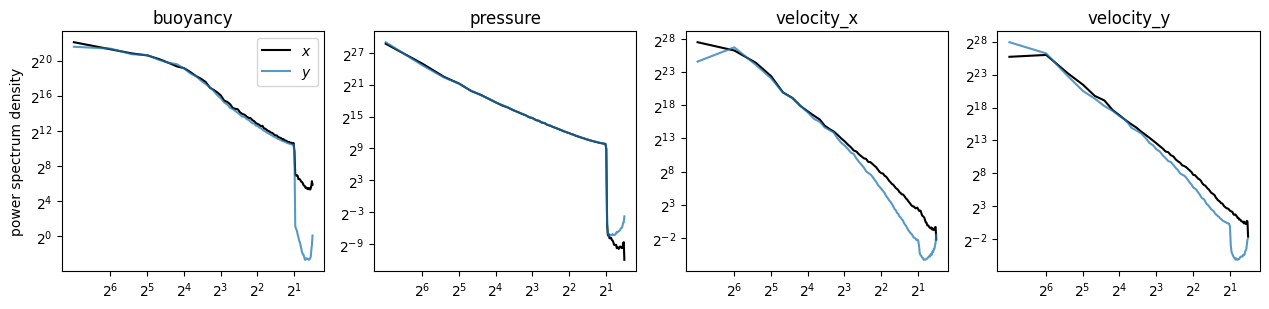

In [10]:
fig = plot_psd(x[:, 16], x_hat[:, 16], fields=cfg.dataset.fields)

## Filtering

In [11]:
def emulate(mask, x_obs, i):
    y = x[:, i : i + cfg.trajectory.length, ::16, ::16]
    A = lambda z: decode_traj(autoencoder, z, batched=True)[..., : y.shape[1], ::16, ::16]
    var_y = 0.0001

    return emulate_diffusion(
        GuidedDenoiser(denoiser, y=y, A=A, var_y=var_y),
        mask,
        x_obs,
        label=label,
        algorithm="pc",
        steps=64,
        corrections=1,
        delta=0.1,
    )


with torch.autocast(device_type=device, enabled=True):
    z_hat = emulate_rollout(
        emulate,
        z,
        window=cfg.trajectory.length,
        rollout=z.shape[1],
        context=1,
        overlap=1,
    )

with torch.no_grad():
    x_hat = decode_traj(autoencoder, z_hat)

In [12]:
frames = torch.stack((x.mT, x_hat.mT))
frames = rearrange(frames, "N C L H W -> L N C H W")

draw_movie(frames, fps=1.0, display=True)

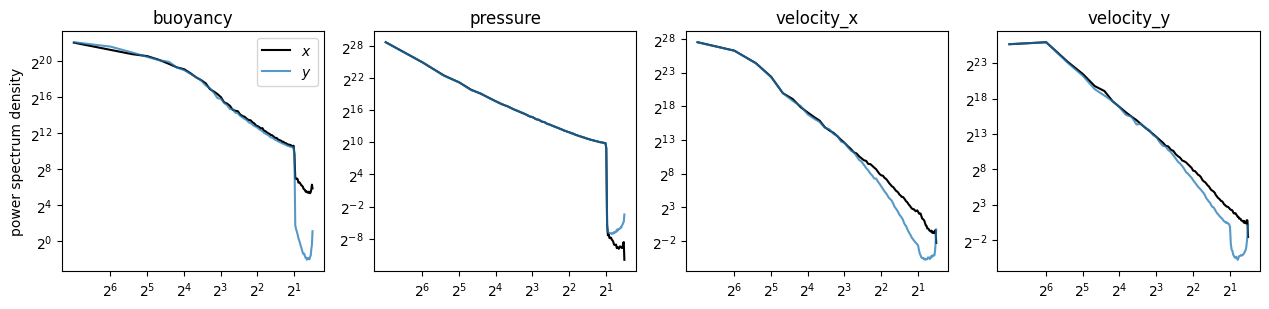

In [13]:
fig = plot_psd(x[:, 16], x_hat[:, 16], fields=cfg.dataset.fields)